<a id='0'></a>
# 1. Introduction
The dataset hosted at arn:aws:s3:::afsis contains field and laboratory measurements of soil samples collected through the Africa Soil Information Service (AfSIS) project, which spanned from 2009 through 2018. Georeferenced soil samples were collected from many countries throughout Sub-Saharan Africa, and their nutrient content was analyzed using both wet chemistry (e.g. Mehlich-3) and dry chemistry (e.g., infrared spectroscopy, x-ray fluorescence). The two types of data can be paired to form a training dataset for machine learning, such that certain nutrients measured by wet chemical analyses can be well predicted from dry chemistry.

## 1.1. Standards for Inclusion
To maximize the utility of this dataset for spectral inference and geospatial mapping, we are only including data satisfying the following constraints:

The soil sample corresponding to this measurement can be associated with a georeference inside Africa.
A dry chemistry measurement is included only if there exists some wet chemistry measurement of the same soil sample.
A wet chemistry measurement is included only if there exists some dry chemistry measurement of the same soil sample.
The chemical analyses of soils were performed by three different labs, all ISO/IEC 17025:2005 certified: the World Agroforestry Centre (ICRAF), Crop Nutrition Laboratory Services Ltd. (CROPNUTS), and Rothamsted Research (RRES). Careful documentation for all procedures used by the labs have also been included in this dataset.

## 1.2. Goal
The aim of this notebook is to wrangle, analyze and treat the datasets from AfSIS to create a predictive model using Machine Learning.

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

<a id='1.2'></a>
## 2.2. Loading the Data

In [ ]:
# load dataset
txrf = read_csv('/content/drive/MyDrive/Data Science/AfSIS/TXRF.csv')
wet = read_csv('/content/drive/MyDrive/Data Science/AfSIS/Wet_Chemistry_CROPNUTS.csv')
dataset = wet

<a id='1.3'></a>
## 2.3. Data Wrangling

In [ ]:
dataset = dataset[["SSN", "Public", "Latitude", "Longitude", "Cultivated", "M3 Al", "M3 B", "M3 Ca",
                   "M3 Cu","M3 Fe", "M3 K", "M3 Mg", "M3 Mn", "M3 Na", "M3 P", "M3 S", "M3 Zn","PH", "PSI"]]
dataset.head()

,SSN,Public,Latitude,Longitude,Cultivated,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,M3 S,M3 Zn,PH,PSI
0,icr025136,True,-6.851620,34.243313,False,446.0,0.110,1123.00,0.39,51.00,74.0,97.00,112.0,23.00,7.130,7.000,2.120,7.010,4.230
1,icr068579,True,11.280658,8.166768,NaN,511.0,0.001,641.00,0.39,95.50,71.4,114.00,27.3,22.00,1.980,4.730,0.790,5.880,17.900
2,icr048978,True,-29.972100,22.710200,False,194.0,0.340,8540.00,0.62,59.60,129.0,217.00,88.4,91.40,6.280,13.200,0.410,8.580,53.600
3,icr056481,True,-16.066365,28.326498,True,1070.0,0.001,1070.00,6.05,68.10,46.8,198.00,136.0,8.83,1.260,8.410,0.630,6.280,86.300
4,icr034190,True,8.158693,9.930640,True,503.1,0.192,695.27,0.51,82.47,92.8,165.41,109.3,34.97,9.342,8.991,0.641,6.707,0.205


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [ ]:
# shape
dataset.shape

(1843, 19)

In [ ]:
# types
set_option('display.max_rows', 500)
dataset.dtypes

,0
SSN,object
Public,bool
Latitude,float64
Longitude,float64
Cultivated,object
M3 Al,float64
M3 B,float64
M3 Ca,float64
M3 Cu,float64
M3 Fe,float64


In [ ]:
# describe data
pd.set_option('display.precision', 3)
dataset.describe()

,Latitude,Longitude,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,M3 S,M3 Zn,PH,PSI
count,1843.000,1843.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000,1839.000
mean,-4.922,22.363,816.088,0.453,1864.879,1.781,112.794,173.203,312.238,100.374,143.499,12.492,25.522,1.546,6.208,75.706
std,12.938,16.846,463.101,1.817,3489.761,2.083,82.213,294.327,420.277,101.755,1188.771,29.187,168.712,1.795,1.074,76.469
min,-29.981,-13.433,1.672,0.000,0.001,0.001,1.260,0.001,0.001,0.570,0.000,0.001,0.000,0.001,3.610,0.000
25%,-16.069,9.348,455.000,0.001,287.050,0.489,60.400,50.790,77.405,24.000,22.000,2.565,5.070,0.720,5.430,21.802
50%,-6.126,29.410,734.000,0.110,626.700,1.120,92.730,89.200,156.000,70.530,34.200,5.010,7.750,1.110,6.080,54.100
75%,8.131,35.500,1098.000,0.370,1707.000,2.436,140.000,172.000,384.000,140.600,51.005,10.190,12.700,1.790,6.690,102.000
max,14.880,48.757,3041.000,55.090,35200.000,23.700,981.000,5047.000,4740.000,686.600,31800.000,396.000,3940.000,36.510,9.860,452.888


We can see that there is a negative value on pressure(PSI) and M3 B which represents a outlier. It could be a uncalibrated equipament or handling error during the measurement. All values that present negative values in pressure will be replaced by 0.

In [ ]:
# Replacing negative values of soil compactation
dataset.loc[dataset['PSI']<0, 'PSI'] = 0
dataset.loc[dataset['M3 B']<0, 'M3 B'] = 0

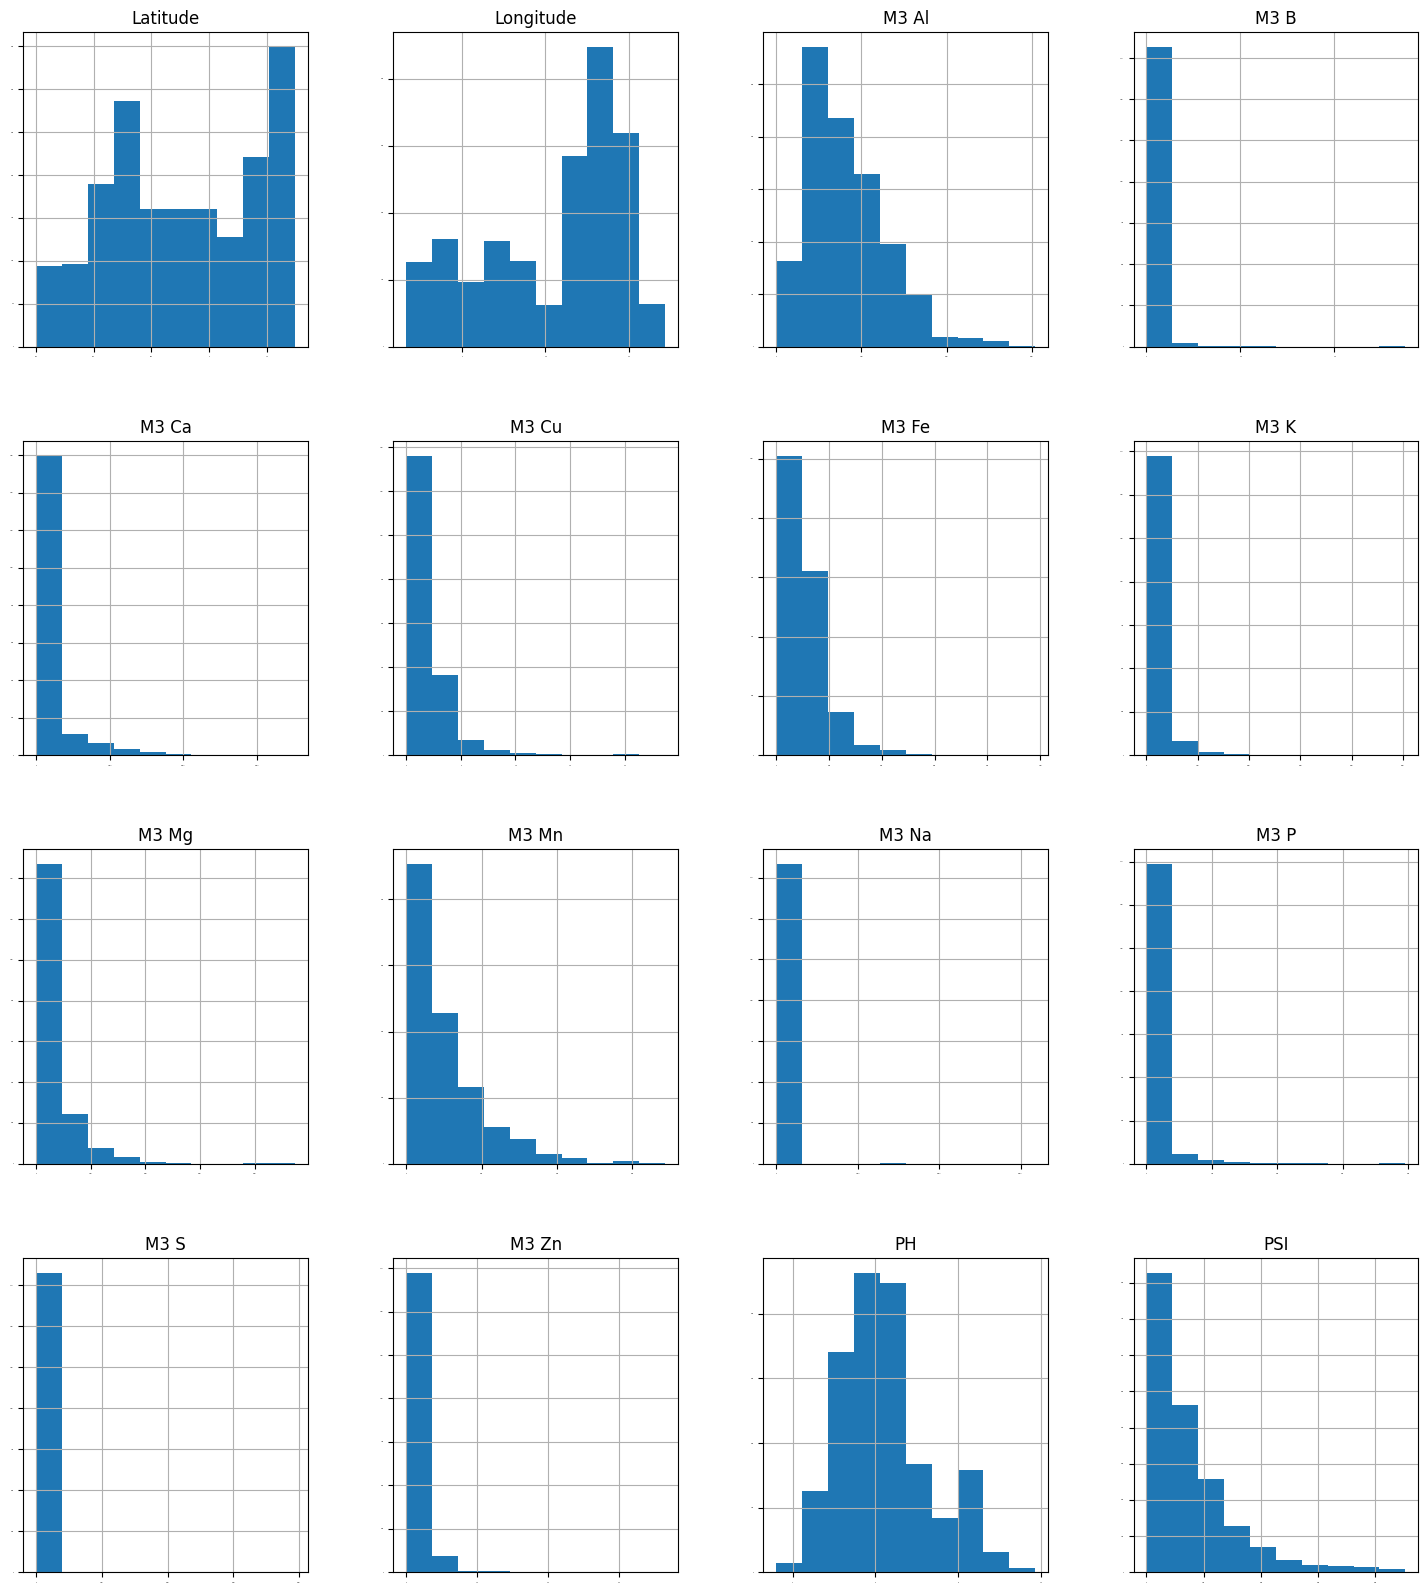

In [ ]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(18,20))
pyplot.show()

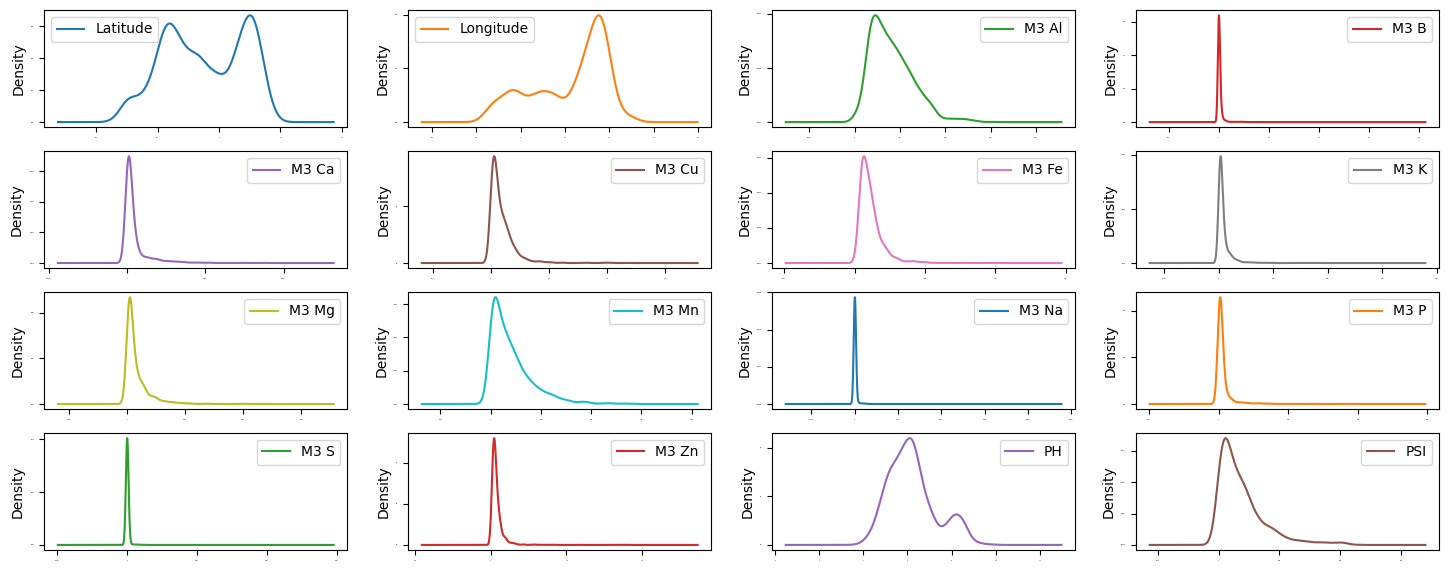

In [ ]:
# density
dataset.plot(kind='density', subplots=True, layout=(10,4), sharex=False, legend=True, fontsize=1, figsize=(18,18))
pyplot.show()

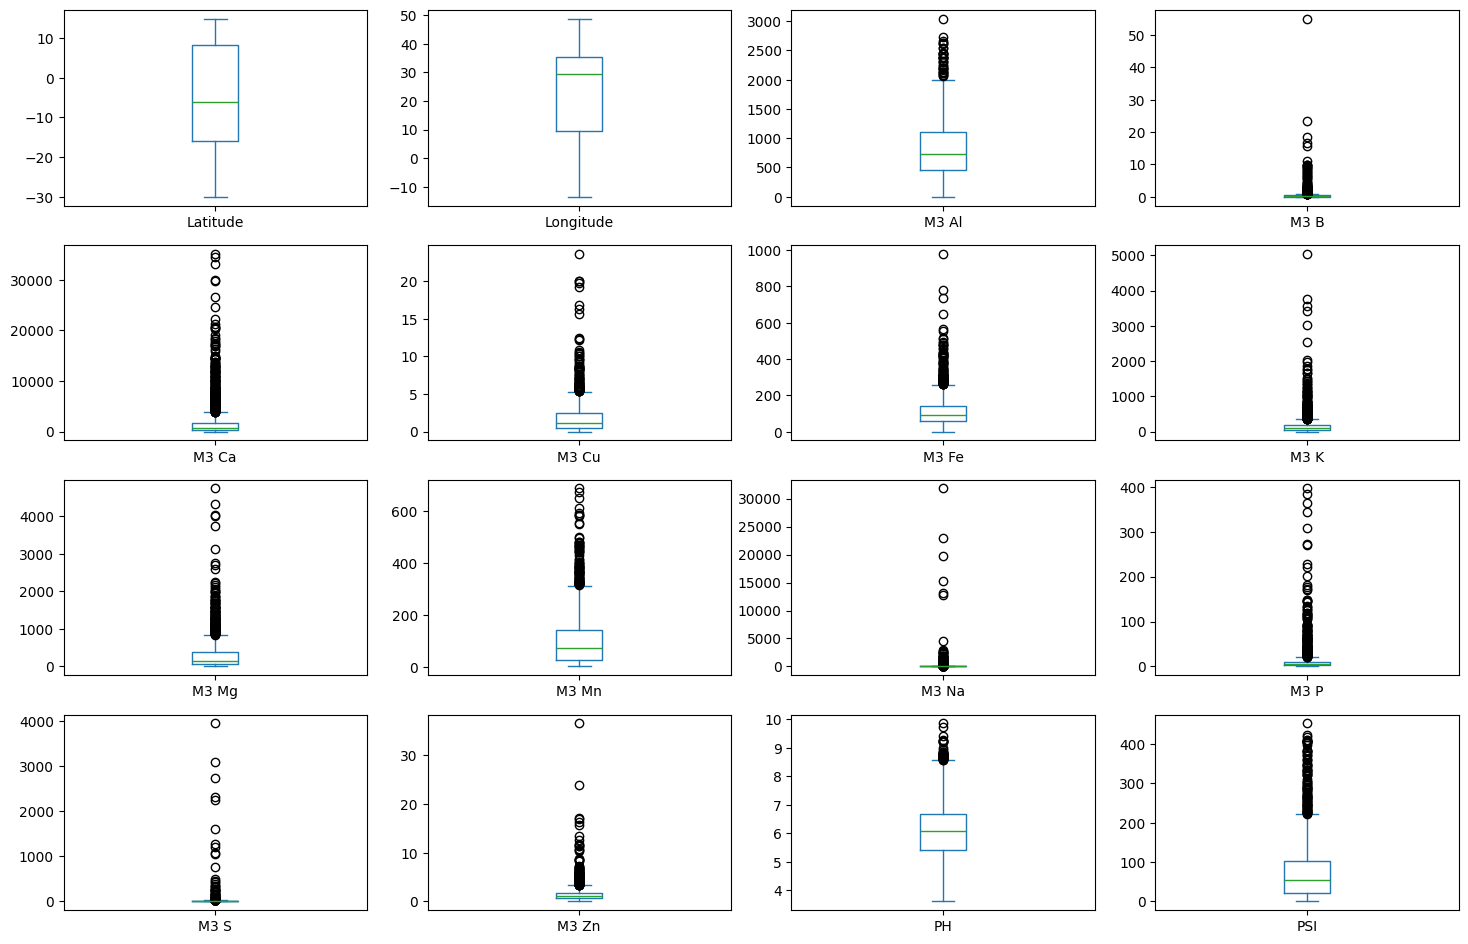

In [ ]:
#Box and Whisker Plots
dataset.plot(kind='box', subplots=True, layout=(10,4), sharex=False, sharey=False, figsize=(18,30))
pyplot.show()

In [ ]:
data_corr = dataset.drop(columns = ['SSN','Public','Cultivated'])
data_corr.head()

,Latitude,Longitude,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,M3 S,M3 Zn,PH,PSI
0,-6.852,34.243,446.0,0.110,1123.00,0.39,51.00,74.0,97.00,112.0,23.00,7.130,7.000,2.120,7.010,4.230
1,11.281,8.167,511.0,0.001,641.00,0.39,95.50,71.4,114.00,27.3,22.00,1.980,4.730,0.790,5.880,17.900
2,-29.972,22.710,194.0,0.340,8540.00,0.62,59.60,129.0,217.00,88.4,91.40,6.280,13.200,0.410,8.580,53.600
3,-16.066,28.326,1070.0,0.001,1070.00,6.05,68.10,46.8,198.00,136.0,8.83,1.260,8.410,0.630,6.280,86.300
4,8.159,9.931,503.1,0.192,695.27,0.51,82.47,92.8,165.41,109.3,34.97,9.342,8.991,0.641,6.707,0.205


<Axes: title={'center': 'Correlation Matrix'}>

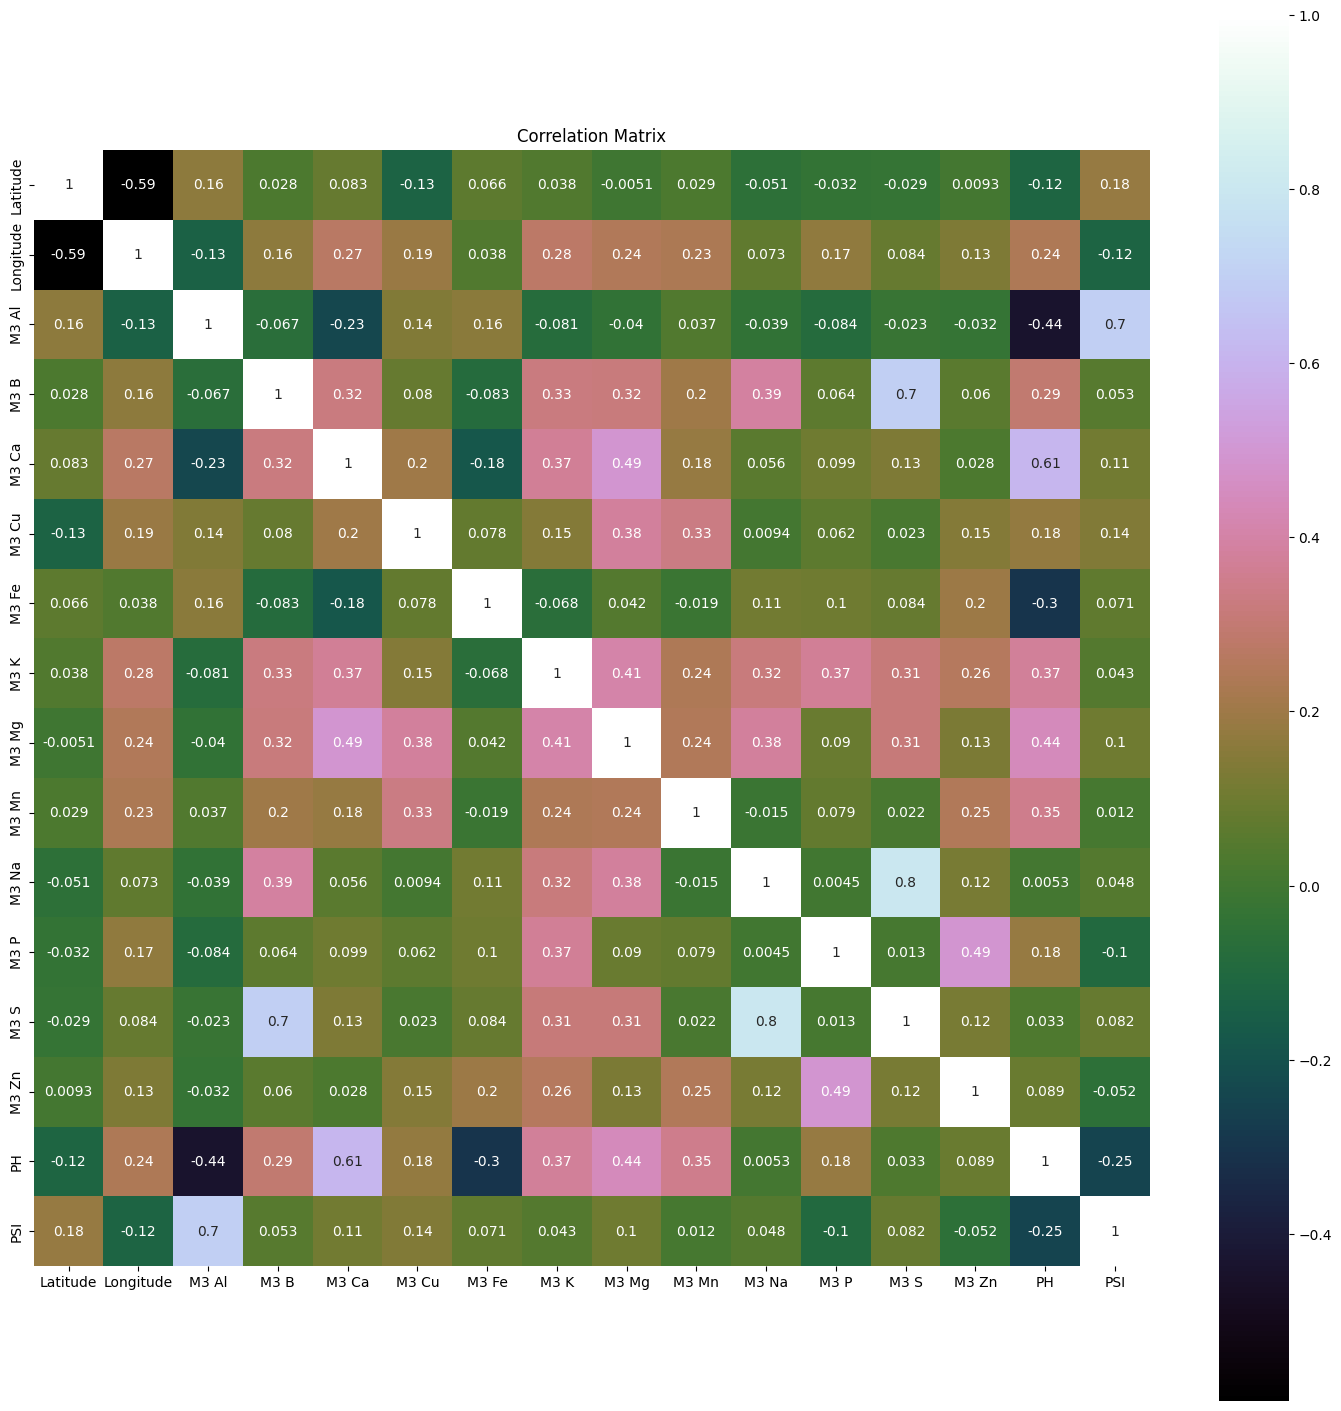

In [ ]:
# correlation
correlation = data_corr.corr()
pyplot.figure(figsize=(18,18))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<a id='3'></a>
## 4. Data Preparation

<a id='3.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [ ]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Given that there are null values drop the rown contianing the null values.

In [ ]:
# Drop the rows containing NA
dataset = dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())
dataset = dataset.drop(columns=['SSN', 'Public','Cultivated'])
print('Null Values =',dataset.isnull().values.any())

Null Values = False


<a id='3.3'></a>
## 4.3. Feature Selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=5)
bestfeatures

SelectKBest(k=5, score_func=<function chi2 at 0x788afd15bec0>)

In [ ]:
X = dataset.loc[:, ['Latitude', 'Longitude']]
Y = dataset.loc[:, ['M3 Al',	'M3 B',	'M3 Ca',	'M3 Cu',	'M3 Fe',	'M3 K',	'M3 Mg',	'M3 Mn',	'M3 Na',	'M3 P',	'M3 S',	'M3 Zn',	'PH',	'PSI']]
#fit = bestfeatures.fit(X,Y)
#dfscores = pd.DataFrame(fit.scores_)
#dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
#featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#featureScores.columns = ['Specs','Score']  #naming the dataframe columns
#print(featureScores.nlargest(10,'Score'))  #print 10 best features

<a id='4.0'></a>

## 4. Data Modeling and Transformation

<a id='4.1'></a>
## 4.1. Train Test Split

In [ ]:
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

<a id='3.4.1'></a>
## 4.2. Rescale Data
When your data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
dataset_pipeline = Pipeline([
    ('min_max', MinMaxScaler(feature_range=(0, 1))),
    ('std_scaler', StandardScaler()),
#    ('norm', Normalizer())
    ])

<a id='4.2'></a>
## 5. Evaluate Algorithms and Models

In [ ]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
scoring ='neg_mean_absolute_error'
#scoring = 'r2'

## 5.1. Model Tuning and Grid Search

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 8. Grid search : RandomForestRegressor
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
rescaledX = dataset_pipeline.fit_transform(X_train)
rescaledY = dataset_pipeline.fit_transform(Y_train)
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = RandomForestRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -85.939344 using {'n_estimators': 100}
-86.536116 (16.581974) with: {'n_estimators': 50}
-85.939344 (17.271438) with: {'n_estimators': 100}
-86.301585 (16.901848) with: {'n_estimators': 150}
-86.022786 (17.039291) with: {'n_estimators': 200}
-86.578377 (16.686696) with: {'n_estimators': 250}
-86.429690 (17.605614) with: {'n_estimators': 300}
-86.236632 (16.968126) with: {'n_estimators': 350}
-86.374299 (17.744172) with: {'n_estimators': 400}


In [ ]:
# 10. Grid search : ExtraTreesRegressor
'''
n_estimators : integer, optional (default=10)
    The number of trees in the forest.
'''
rescaledX = dataset_pipeline.fit_transform(X_train)
rescaledY = dataset_pipeline.fit_transform(Y_train)

param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -83.931792 using {'n_estimators': 400}
-84.199137 (18.484040) with: {'n_estimators': 50}
-83.985677 (18.559427) with: {'n_estimators': 100}
-84.058871 (18.649675) with: {'n_estimators': 150}
-83.997172 (18.616899) with: {'n_estimators': 200}
-83.943787 (18.499846) with: {'n_estimators': 250}
-83.943887 (18.561000) with: {'n_estimators': 300}
-83.931991 (18.532572) with: {'n_estimators': 350}
-83.931792 (18.538361) with: {'n_estimators': 400}


# 6. Finalising the Model

## 6.1. Results on the Test Dataset

In [ ]:
# prepare model
#scaler = StandardScaler().fit(X_train)
#rescaledX = scaler.transform(X_train)
rescaledX = dataset_pipeline.fit_transform(X_validation)
rescaledY = dataset_pipeline.fit_transform(Y_validation)
model = RandomForestRegressor(n_estimators=100) # rbf is default kernel
model.fit(rescaledX, Y_validation)

RandomForestRegressor()

In [ ]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
rescaledX = dataset_pipeline.fit_transform(X_validation)
predictions = model.predict(rescaledX)
print(mean_absolute_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

44.1980939040348
0.876895263605911


In [ ]:
predictions

array([[1.01032639e+03, 5.18746071e-01, 5.51798464e+03, ...,
        2.16446107e+00, 6.49591679e+00, 1.17870844e+02],
       [4.75564000e+02, 7.44490000e-01, 5.27820000e+02, ...,
        1.90147000e+00, 6.01659000e+00, 3.79243700e+01],
       [6.98560000e+02, 1.00000000e-03, 2.04023000e+02, ...,
        5.17900000e-01, 5.20300000e+00, 6.60180000e+01],
       ...,
       [1.14782667e+03, 1.00000000e-03, 1.62155000e+02, ...,
        1.25194000e+00, 5.08507000e+00, 6.78135667e+01],
       [6.11219000e+02, 4.11378000e-01, 1.48572400e+03, ...,
        3.38304000e+00, 6.62693000e+00, 3.52547581e+01],
       [2.65150000e+02, 3.30600000e-02, 1.93918000e+02, ...,
        6.60600000e-01, 6.04570000e+00, 1.52120000e+00]])

<a id='6.3'></a>
## 6.2. Save Model for Later Use

In [ ]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'predict_afsis.sav'
dump(model, open(filename, 'wb'))

In [ ]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
rescaledValidationX = dataset_pipeline.fit_transform(X_validation)
predictions = model.predict(rescaledValidationX)
#predictions = model.predict(X_validation)
result = mean_absolute_error(Y_validation, predictions)
print(result)

44.1980939040348


In [ ]:
predictions

array([[1.01032639e+03, 5.18746071e-01, 5.51798464e+03, ...,
        2.16446107e+00, 6.49591679e+00, 1.17870844e+02],
       [4.75564000e+02, 7.44490000e-01, 5.27820000e+02, ...,
        1.90147000e+00, 6.01659000e+00, 3.79243700e+01],
       [6.98560000e+02, 1.00000000e-03, 2.04023000e+02, ...,
        5.17900000e-01, 5.20300000e+00, 6.60180000e+01],
       ...,
       [1.14782667e+03, 1.00000000e-03, 1.62155000e+02, ...,
        1.25194000e+00, 5.08507000e+00, 6.78135667e+01],
       [6.11219000e+02, 4.11378000e-01, 1.48572400e+03, ...,
        3.38304000e+00, 6.62693000e+00, 3.52547581e+01],
       [2.65150000e+02, 3.30600000e-02, 1.93918000e+02, ...,
        6.60600000e-01, 6.04570000e+00, 1.52120000e+00]])

Convertendo o array predicitions em um dataframe para comparação com o original

In [ ]:
predictions_df = pd.DataFrame(predictions, columns = ['M Al',	'M B', 'M Ca',	'M Cu',	'M Fe',	'M K',	'M Mg',	'M Mn',	'M Na',	'M P',	'M S',	'M Zn',	'M PH',	'M PSI'])
compare_df = pd.concat([Y_validation.reset_index(drop=True), predictions_df], axis=1)
compare_df.head()

,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,...,M Fe,M K,M Mg,M Mn,M Na,M P,M S,M Zn,M PH,M PSI
0,1022.0,0.463,5279.1,1.617,190.4,192.491,922.40,65.00,79.78,7.421,...,197.264,256.361,1038.318,90.608,76.438,23.878,10.791,2.164,6.496,117.871
1,469.0,0.001,449.0,0.580,159.0,64.700,162.00,33.60,80.50,1.530,...,202.008,241.511,474.569,23.401,2601.566,5.935,437.766,1.901,6.017,37.924
2,686.0,0.001,258.0,0.900,220.0,49.200,34.60,3.57,30.60,4.640,...,176.313,61.399,38.916,4.044,27.593,4.450,6.330,0.518,5.203,66.018
3,813.6,0.115,431.9,0.835,109.8,73.940,83.57,150.90,25.38,10.030,...,122.030,148.877,117.018,175.839,25.994,11.763,4.261,1.619,6.410,8.013
4,3041.0,0.001,912.0,0.640,47.0,60.000,188.00,7.00,47.00,0.740,...,65.200,67.280,218.430,15.160,51.300,1.585,7.020,0.946,5.843,236.059


In [ ]:
# Splitting the dataset to test
df = txrf

df = df[["SSN", "Public", "Latitude", "Longitude", "M3 Al", "M3 B", "M3 Ca",
         "M3 Cu","M3 Fe", "M3 K", "M3 Mg", "M3 Mn", "M3 Na", "M3 P", "M3 S", "M3 Zn","PH", "PSI"]]

df = df.dropna()

In [ ]:
df.head()

,SSN,Public,Latitude,Longitude,M3 Al,M3 B,M3 Ca,M3 Cu,M3 Fe,M3 K,M3 Mg,M3 Mn,M3 Na,M3 P,M3 S,M3 Zn,PH,PSI
0,icr025136,True,-6.852,34.243,36986.5,0.110,1948.2,1.7,2657.0,55989.9,5575.0,135.7,22934.9,50.6,45.7,5.6,7.010,4.230
1,icr068579,True,11.281,8.167,17762.4,0.001,930.3,5.6,10646.8,25609.9,5575.0,147.7,53747.8,50.6,45.7,15.5,5.880,17.900
2,icr048978,True,-29.972,22.710,41623.2,0.340,39746.3,33.8,40179.2,25832.4,35330.1,795.0,16463.7,231.5,45.7,69.0,8.580,53.600
3,icr056481,True,-16.066,28.326,39672.9,0.001,2330.9,36.6,46402.6,13024.0,5575.0,328.4,19328.2,50.6,45.7,19.3,6.280,86.300
4,icr034190,True,8.159,9.931,14025.2,0.192,734.1,6.6,8652.3,1809.0,5575.0,152.4,21788.9,48.7,45.7,6.7,6.707,0.205


In [ ]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
rescaledValidationX = dataset_pipeline.fit_transform(df.iloc[:,1:3])
predictions = model.predict(rescaledValidationX)
#predictions = model.predict(X_validation)

#data_predict['M Al',	'M B', 'M Ca',	'M Cu',	'M Fe',	'M K',	'M Mg',	'M Mn',	'M Na',	'M P',	'M S',	'M Zn',	'PH',	'PSI'] = predictions.tolist()
test = pd.concat([df.iloc[:,0:4], pd.DataFrame(predictions, columns=['M Al',	'M B', 'M Ca',	'M Cu',	'M Fe',	'M K',	'M Mg',	'M Mn',	'M Na',	'M P',	'M S',	'M Zn',	'PH',	'PSI'])], axis=1)

In [ ]:
test.head()

,SSN,Public,Latitude,Longitude,M Al,M B,M Ca,M Cu,M Fe,M K,M Mg,M Mn,M Na,M P,M S,M Zn,PH,PSI
0,icr025136,True,-6.852,34.243,799.913,0.125,1337.730,3.978,153.835,133.889,286.652,132.700,49.055,8.290,23.456,1.784,5.812,68.000
1,icr068579,True,11.281,8.167,699.188,0.438,1573.774,0.613,148.323,102.096,328.342,76.787,30.258,19.459,8.932,2.604,6.360,35.258
2,icr048978,True,-29.972,22.710,843.586,0.376,1138.504,2.356,145.602,95.462,259.130,136.546,46.174,4.841,13.014,1.687,6.211,71.493
3,icr056481,True,-16.066,28.326,749.435,0.395,1386.706,2.649,156.672,109.451,318.248,144.300,43.201,7.474,16.328,1.882,5.973,63.900
4,icr034190,True,8.159,9.931,699.188,0.438,1573.774,0.613,148.323,102.096,328.342,76.787,30.258,19.459,8.932,2.604,6.360,35.258
